Dynamic Bernoulli Embeddings (D-EMB), discussed [here](http://www.cs.columbia.edu/~blei/papers/RudolphBlei2018.pdf), are a way to train word embeddings that smoothly change with time. After finding the the [paper authors' code](https://github.com/mariru/dynamic_bernoulli_embeddings) a bit challenging to use, I decided to create [my own implementation](https://github.com/llefebure/dynamic_bernoulli_embeddings). This post walks through that process and showcases some results of training the model on the UN General Debate corpus.

## Motivation

I [previously wrote](https://towardsdatascience.com/exploring-the-un-general-debates-with-dynamic-topic-models-72dc0e307696) about using Dynamic Topic Models to model the evolution of topics in the UN General Debate corpus. This analysis produced some interesting results that gave a nice overview of how persistent topics of global interest have changed over time. For example, the model captured the evolution on discussion about Africa from the end of colonialism, to apartheid, and now most recently to democracy and elections.

![africa](africa.png)

I have been interested in this idea of modelling the change of topics and language over time, so I wanted to take this analysis a bit further. Specifically, any kind of topic model forces you to work with the high level topics that the model discovers, but I wanted to be able to slice the data at a more granular level with questions like:
* What terms have changed the most over time?
* For a specific topic like "Syria", can I chart it's evolution through the years?

## Deciding on the D-EMB Model

There has been some research into the idea of word embeddings that evolve over time, such as [Temporal Analysis of Language Through Neural Language Models](https://www.aclweb.org/anthology/W14-2517.pdf) and [Diachronic Word Embeddings Reveal Statistical Laws of Semantic Change](https://www.aclweb.org/anthology/P16-1141.pdf). The former basically trains a Word2Vec model on each timestep, using as initial values the embeddings learned from the previous timestep. The latter builds on this idea slightly by adding an alignment step between the embeddings at different timesteps. The rationale for that is that Word2Vec can result in arbitrary orthogonal transformations that preserve meaningful cosine distance relationships between words in the same timestep but potentially confound any meaningful comparison across timesteps.

After trying this approach and seeing subpar results, I turned to [Dynamic Embeddings for Language Evolution](http://www.cs.columbia.edu/~blei/papers/RudolphBlei2018.pdf), the focus of this post. The authors of this paper have two main critiques for the above approaches. First, they require a lot of data for each timestep to train high quality embeddings (not the case in the UNGD corpus), and second, the necessity of having to do a weird post-training alignment step to make the dimensions of the embdedding comparable across timesteps is not ideal.

## The Model

The model itself is quite simple with just two types of trainable parameters. The first is a separate embedding vector for each term in each timestep, and the second is a time independent context vector for each term.

Training the model is conceptually very similar to training Word2Vec using negative sampling with one addition that encodes a smooth temporal transition for embeddings. This comes in the form of a penalty term on the difference between embedding matrices at different timesteps.

## Implementation Notes

* The embeddings are represented in a single matrix, with timesteps stacked on top of each other. Specifically, we have a tensor of shape `(V * T, k)` where `V` is the vocabulary size, `T` is the number of timesteps, and `k` is the dimension of the embedding. The first `V` rows correspond to the embeddings from the first timestep, the second `V` to the embeddings from the second timestep, etc.

* The implementation effectively concatenates all texts from a given timestep into one, treating it as a continuous stream of words. The impact of this is that the context for a target word at the very end of a text may include a few words from the beginning of some other unrelated text (within the same timestep). This is no problem if your texts are long, but it may be a problem with shorter texts. I may build in support for respecting such boundaries in the future.

* The range of values for the scaling factor on the random walk prior ($\lambda = [1, 10]$) that the paper cites are an order of magnitude different than what the defaults in the authors' code suggests. I think this suggested range is supposed to refer $\lambda_0 = [1, 10]$ where $\lambda = 1000 * \lambda_0$ as this is more in line with the defaults in the code and what ended up working for me.

* The first epoch is used for initialization of the embeddings. To do this, I treat everything in the first epoch as coming from the first timestep and ignore the random walk prior term in the loss. When the epoch is finished, I initialize the embeddings for every timestep with those of the first timestep. The authors of the paper suggested a similar approach.

* 10% of the documents are held out for validation by default. The only metric computed on the validation set is the $L_{pos}$ value, which is basically how good the model is at predicting the target word given the context. No negative samples are drawn for the validation set.

## Results on the General Debate Corpus

### Training

There are multiple components to the loss function that we're minimizing, and the overall loss is a weighted combination of these.

* Positive: How good is the model at positively predicting the target word from the context?
* Negative: How good is the model at negatively predicting the negative samples from the context?
* Prior: How far are the embeddings drifting between timesteps?

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
import numpy as np
loss_curves = pd.read_csv("/Users/lukelefebure/Downloads/loss_history.csv")

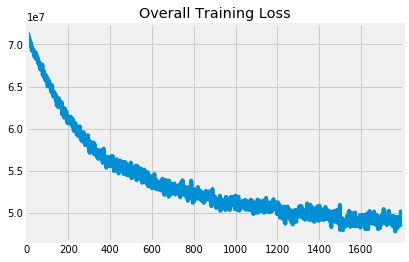

In [2]:
loss_curves.loss.plot(title = "Overall Training Loss");

Let's look at how this decomposes. These three components all have their signs flipped when contributing to the loss, so we hope to see them increasing. The positive and negative curves both do so nicely, while the prior curve is decreasing. This means that the prior term is contributing more and more to the loss over time, despite the loss decreasing. Intuitively though, this makes sense because we want the embeddings to drift, just not too far. Thus, getting the scaling factor correct on this term is crucial to ensure quality embeddings within timesteps and meaningful comparisons across timesteps.

Note the dips at the end of each epoch in the positive and negative curves. These are a consequence of the last batch being slightly smaller. They are normalized before contributing to the overall loss which is why the overall loss curve has no unusual behavior at the end of each epoch.

Finally, we can look at the positive component on the validation set to ensure that the model is generalizing.

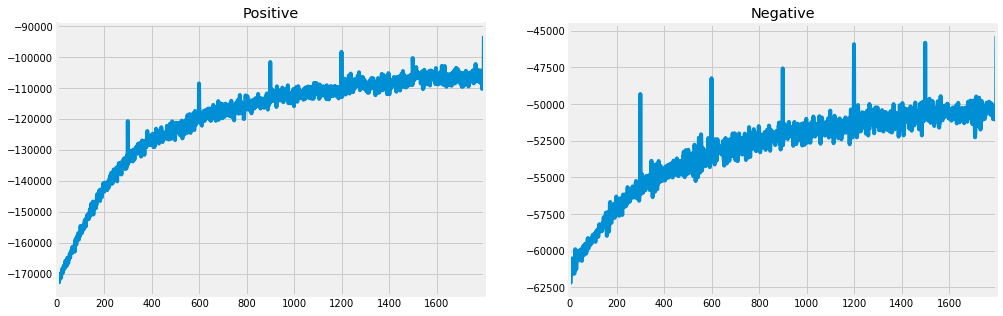

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
loss_curves.l_pos.plot(title="Positive", ax=ax[0]);
loss_curves.l_neg.plot(title="Negative", ax=ax[1]);

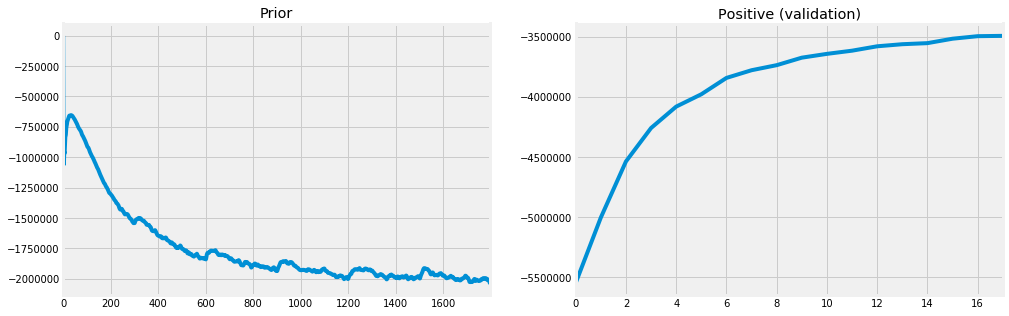

In [4]:
v = loss_curves.l_pos_val.values
v = v[~np.isnan(v)]
fig, ax = plt.subplots(1, 2, figsize=(15,5))
loss_curves.l_prior.plot(title="Prior", ax=ax[0]);
pd.Series(v).plot(title="Positive (validation)", ax=ax[1]);

### Analysis

We can use the trained embeddings to do some cool analysis such as:
* finding which embeddings changed the most over time (absolute drift)
* looking for change points where an embedding significantly changed from one timestep to the next indicating some significant event
* looking up the nearest neighbors of an embedding and seeing how this "neighborhood" has changed over time

Let's start by looking at absolute drift, which is the euclidean distance between the embeddings of each term at the first and last timesteps. Terms that drifted the most indicate that their usage has shifted.

Climate comes out on top, and European and Union appear which makes sense given the founding of the EU only in 1993 (and subsequent frequent usage of European and Union together). Millenium and Sustainable likely have to do in part with the advent of the Millenium and Sustainable Development Goals initiatives, and countries/regions that have seen significant change such as Syria and Africa also appear near the top.

In [5]:
from dynamic_bernoulli_embeddings.analysis import DynamicEmbeddingAnalysis
import numpy as np
import pickle
token_to_id = pickle.load(open("/Users/lukelefebure/Downloads/dictionary.pkl", "rb"))
embeddings = np.load("/Users/lukelefebure/Downloads/embeddings.npy")
emb = DynamicEmbeddingAnalysis(embeddings, token_to_id)

In [6]:
pd.DataFrame(emb.absolute_drift(20), columns=["Drift", "Term"])[["Term", "Drift"]]

,Term,Drift
0,climate,1.241559
1,union,1.221671
2,south,1.136769
3,co,0.985926
4,agenda,0.983631
5,change,0.951607
6,post,0.912055
7,european,0.889426
8,southern,0.888166
9,twenty,0.878703


We can take this idea of measuring embedding drift further by finding the term/timestep pairs corresponding to the largest single timestep changes. I call these "change points", and they correlate with significant real world events. For example, the Arab Spring begain in Tunisia in 2010 and Iranian appears twice in consecutive years in this list after details of the Iran-Contra Affair emerged.

In [24]:
pd.DataFrame([(1970 + i, term, change) for i, term, change in emb.change_points(10)], columns=["Year", "Term", "Change"])

,Year,Term,Change
0,1993,ukraine,0.257642
1,2010,tunisia,0.232226
2,2014,japan,0.231548
3,1987,iranian,0.226282
4,1986,iranian,0.218671
5,1985,rwanda,0.207307
6,1993,lebanon,0.201297
7,2000,sudan,0.201279
8,1985,italy,0.201008
9,1999,sudan,0.200704


Finally, we can look at a term's neighborhood in the embedding space across time. Let's look at climate since it was found to have changed the most.

In [25]:
over_time = {}
for i in range(0, 46 + 1, 5):
    col = str(1970 + i)
    over_time[col] = emb.neighborhood("climate", i, 5, sign=False)
pd.DataFrame(over_time)

,1970,1975,1980,1985,1990,1995,2000,2005,2010,2015
0,atmosphere,atmosphere,atmosphere,atmosphere,atmosphere,atmosphere,winds,winds,winds,climatic
1,détente,equilibrium,relaxation,relaxation,dynamics,winds,radical,radical,radical,ipcc
2,equilibrium,détente,détente,détente,winds,climatic,climatic,climatic,climatic,winds
3,dynamics,dynamics,equilibrium,equilibrium,détente,radical,atmosphere,ipcc,ipcc,radical
4,relaxation,relaxation,dynamics,realms,momentum,engendering,ipcc,impacts,resistant,bioenergy


## Conclusion

Like Dynamic Topic Models, dynamic word embeddings provide an interesting lens into how language usage changes over time. Applied to the UN General Debate corpus, we saw how they can tell us what terms are changing the most and point us directly to interesting change points that correlate with significant real world events.

The code is easy to use, pip installable, and located [here](https://github.com/llefebure/dynamic_bernoulli_embeddings). I hope it can be useful for others interested in similar exploratory analyses!

In [43]:
from IPython.display import HTML
over_time = {}
v = "climate"
for i in range(0, 46 + 1, 5):
    col = str(1970 + i)
    over_time[col] = emb.neighborhood(v, i, 5, sign=False)
table = pd.DataFrame(over_time).to_html()
HTML(f"<h3><center>\"{v.title()}\" Nearest Neighbors</center></h3>{table}")

,1970,1975,1980,1985,1990,1995,2000,2005,2010,2015
0,atmosphere,atmosphere,atmosphere,atmosphere,atmosphere,atmosphere,winds,winds,winds,climatic
1,détente,equilibrium,relaxation,relaxation,dynamics,winds,radical,radical,radical,ipcc
2,equilibrium,détente,détente,détente,winds,climatic,climatic,climatic,climatic,winds
3,dynamics,dynamics,equilibrium,equilibrium,détente,radical,atmosphere,ipcc,ipcc,radical
4,relaxation,relaxation,dynamics,realms,momentum,engendering,ipcc,impacts,resistant,bioenergy
